# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 3b: Feature selection, ML modelling and ablation study (feature-based audio model)
- Full Dataset: All features (from previous notebook 2b)
- Ablated Dataset 1: Features after removing those with Pearson correlation > 0.97 (within audio modality).
- Ablated Dataset 2: Features after removing those with Pearson correlation > 0.9 (within audio modality).
- Ablated Dataset 3: Features from Ablated Dataset 1 with MI > 0.05.
- Ablated Dataset 4: Features from Ablated Dataset 1 with MI > 0.1.

In [1]:
import os
import glob
import sys
import math
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from pandas import DataFrame
import scipy as sp
import itertools
from collections import defaultdict
from pprint import pprint
import pickle

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from pylab import *
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

# Scikit-learn general
from sklearn import preprocessing, metrics, svm, datasets, tree, neighbors
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, scale
from sklearn.ensemble import HistGradientBoostingClassifier

# Scikit-learn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier

# Imbalanced learn
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

# XGBoost and LightGBM
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Utilities
from scipy.stats import uniform, randint
from scipy.interpolate import griddata
from sklearn.utils import shuffle, resample, class_weight
from utils import *
from joblib import dump, load
np.random.seed(0)

/tmp/ipykernel_92696/2296993266.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def display_left_wide(df, column_width=800):
    # Adjust the max column width
    pd.set_option('display.max_colwidth', column_width)

    # Display the dataframe on the left with custom column width
    left_aligned_df = '<div style="float: left;">{}</div>'.format(df.to_html())
    display(HTML(left_aligned_df))

In [3]:
PROJECT_ROOT_DIR = "../"

IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'ML-baseline', 'ablation study')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'ML-baseline', 'ablation study')
scaler_path = os.path.join(PROJECT_ROOT_DIR, "saved_scalers", 'defect classification',  'ML-baseline', 'ablation study')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
              

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [4]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [5]:
val_indices

array([2923, 2390, 2534, 1233, 1674, 5064, 6125, 1136, 1514, 5402, 3271,
       4890, 5684, 4870, 2757, 3607, 4408, 1248,  358,  973,  583, 2771,
       4829, 2734, 3003,  265, 6025, 1166,  769,  802, 4688, 1866, 5542,
       1926, 3313, 6178, 1994, 1448, 3238, 1557, 1112, 3486, 4330, 5103,
       6136,  845, 1133, 1148, 2322, 2650,  496, 1511,  908, 1656, 1820,
       4643, 1475, 5612, 2157,  864, 5799, 4218, 2452,  337,  844,  495,
       1624, 2853,  453, 2562, 3694, 3094,  811, 5420, 3781, 4188, 2374,
       2691, 3955, 6019, 2631,  440, 5759, 5153,  432, 3802, 3967, 2652,
       2162, 2713, 4211, 5651, 3054, 1753, 5210, 3748, 5514, 2567, 4205,
       2265,  714, 1719,  710, 4244, 6062,  857, 3554,  471, 4891, 4149,
       5362, 1975, 2046, 4869, 5807, 4087,  127, 3148,  653,  394, 5272,
        785, 4964,  288, 5483, 3766, 4291, 1901, 2441, 3664, 2344, 4144,
       3557, 6150, 3245, 3533, 5741, 1533, 3596, 4308, 4728, 4541,  271,
       2931, 6157, 4267,  678, 6171, 2110, 4061, 24

## Load Dataset

In [6]:
%store -r datasets
%store -r le
%store -r Y_encoded

In [7]:
datasets

{'All Features': array([[ 3.17460597e-02,  3.89823429e-02,  1.43036339e-02, ...,
          6.36536217e+00, -4.25530243e+00,  6.84352922e+00],
        [ 4.69362400e-02,  5.34921885e-02,  1.87268574e-02, ...,
          6.29292870e+00, -4.17497969e+00,  7.59553719e+00],
        [ 2.42218133e-02,  3.33609357e-02,  1.39142405e-02, ...,
          9.25216484e+00, -2.73436689e+00,  4.95732212e+00],
        ...,
        [ 1.22464793e-02,  1.48045355e-02,  5.10020321e-03, ...,
          6.38746643e+00, -1.07345905e+01,  8.09787750e+00],
        [ 1.33671844e-02,  1.65460929e-02,  5.38443821e-03, ...,
          4.76326370e+00, -1.38471327e+01,  7.91168976e+00],
        [ 1.29805105e-02,  1.56615954e-02,  5.63964201e-03, ...,
          5.72218609e+00, -1.30503092e+01,  7.41869259e+00]]),
 'Ablated 1': array([[ 1.43036339e-02,  6.43990934e-02, -3.72418060e+01, ...,
          6.36536217e+00, -4.25530243e+00,  6.84352922e+00],
        [ 1.87268574e-02,  3.37868482e-02, -3.70896606e+01, ...,
         

In [8]:
class_weights_encoded = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_encoded),
                                                 y = Y_encoded)


class_names = (le.classes_).tolist()
print(f"class weights encoded: {class_weights_encoded}")
print(f"class        : {class_names}")

class weights encoded: [1.6284585  3.41436464 5.44493392 0.34515498 0.98800959]
class        : ['Balling', 'Degradation', 'LOF', 'Laser-off', 'Non-defective']


In [9]:
# List of models
model_names = ['KNN', 'DT', 'RF', 'BalancedRF', 'RUSBoost', 'Ada', 'NN', 'XGBoost', 'LightGBM', 'SVM', 'HistGB']

### Basic Evaluation Metrics


In [10]:
from joblib import dump, load
def evaluate_saved_models(model_path, datasets, kf, model_names, Y_encoded, train_indices, val_indices, test_indices, le, n_runs=10):
    """
    Load and evaluate pre-trained models.

    Parameters:
    - model_path (str): Directory where the pre-trained models are saved.
    - datasets (dict): Dictionary containing the names of datasets as keys and features as values.
    - kf (KFold): KFold cross-validator.
    - model_names (list): List of model names to evaluate.
    - Y_encoded (array): Array of encoded labels.
    - train_indices (array): Indices for training set.
    - val_indices (array): Indices for validation set.
    - test_indices (array): Indices for test set.
    - le (LabelEncoder): Pre-fitted LabelEncoder for class names.
    - n_runs (int): Number of runs to measure inference time.

    Returns:
    - final_results_df (DataFrame): DataFrame containing evaluation metrics.
    """
    # Create a dictionary to store final results
    final_results = defaultdict(list)
    
    # Create a dictionary to store temporary cross-validation results for each dataset and model
    cv_results = defaultdict(lambda: defaultdict(list))

    # Iterate over datasets and models
    for dataset_name, X in datasets.items():
        print(f"Processing dataset: {dataset_name}")
        
        # Split data
        X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
        y_train, y_val, y_test = Y_encoded[train_indices], Y_encoded[val_indices], Y_encoded[test_indices]
        
        # Scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        # Load the model
        for model_name in model_names:
            print(f"Evaluating model: {model_name}")
            
            model_file = os.path.join(model_path, f"{model_name}_{dataset_name}.joblib")
            model = load(model_file)

            #### -------Loop through all models and measure inference time----------###
            # Initialize metrics for inference time
            inference_times = []
            times = []
            X_val_subset = X_val[:1000]
            for _ in range(n_runs):
                start_time = time.perf_counter()
                predictions = model.predict(X_val_subset)
                end_time = time.perf_counter()
                times.append(end_time - start_time)
            # Calculate average and standard deviation
            avg_time = np.mean(times)
            std_time = np.std(times)

            print(f"Inference Time: Mean = {avg_time:.6f} milliseconds, Std = {std_time:.6} milliseconds")
            cv_results[dataset_name][f"{model_name}_Inference Time_mean"] = avg_time
            cv_results[dataset_name][f"{model_name}_Inference Time_std"] = std_time
            ####-------Loop through all models and measure inference time----------###

            
            ###-------Confusion matrix: lass-specific accuracy-------------####
            # Initialize metrics for class-specific accuracy
            class_accuracies = defaultdict(list)
            # Calculate class-specific accuracies
            y_test_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_test_pred)
            class_acc = cm.diagonal() / cm.sum(axis=1)
            for i, acc in enumerate(class_acc):
                class_name = le.inverse_transform([i])[0]  # Convert encoded class to original string name
                class_accuracies[class_name].append(acc)            
                
            # Calculate mean and std for class-specific accuracies
            for class_name, accuracies in class_accuracies.items():
                mean_acc = np.mean(accuracies)
                std_acc = np.std(accuracies)
                cv_results[dataset_name][f"{model_name}_{class_name}_mean"] = mean_acc
                cv_results[dataset_name][f"{model_name}_{class_name}_std"] = std_acc
                # Print the mean and std for the accuracy of the class "Keyhole pores" if it exists
                if class_name == "Balling":
                    print(f"Class 'Balling': Accuracy Mean = {mean_acc}, Std = {std_acc}")
                elif class_name == "Non-defective":
                    print(f"Class 'Non-defective': Accuracy Mean = {mean_acc}, Std = {std_acc}")
                elif class_name == "Laser-off":
                    print(f"Class 'Laser-off': Accuracy Mean = {mean_acc}, Std = {std_acc}")
            ###-------Confusion matrix: lass-specific accuracy-------------####
                    
            ###-------------5-fold cross-validation -----------
            # Initialize fold metrics
            fold_metrics = defaultdict(list)
            for train_idx, test_idx in kf.split(X_test):
                X_test_train, X_test_val = X_test[train_idx], X_test[test_idx]
                y_test_train, y_test_val = y_test[train_idx], y_test[test_idx]
                
                # Make predictions
                y_test_pred = model.predict(X_test_val)

                # Calculate metrics
                acc = accuracy_score(y_test_val, y_test_pred)
                f1 = f1_score(y_test_val, y_test_pred, average='weighted')
                precision = precision_score(y_test_val, y_test_pred, average='weighted')
                recall = recall_score(y_test_val, y_test_pred, average='weighted')

                try:
                    roc_auc = roc_auc_score(y_test_val, model.predict_proba(X_test_val), multi_class='ovr', average='weighted')
                except:
                    roc_auc = 'N/A'

                # Store the metrics for this fold
                fold_metrics['Accuracy'].append(acc)
                fold_metrics['F1 Score'].append(f1)
                fold_metrics['Precision'].append(precision)
                fold_metrics['Recall'].append(recall)
                fold_metrics['ROC-AUC'].append(roc_auc if roc_auc != 'N/A' else np.nan)
                    
            # -------Calculate mean and std for each metric------------
            for metric, values in fold_metrics.items():
                mean_val = np.nanmean(values)
                std_val = np.nanstd(values)
                print(f"{metric}: Mean = {mean_val}, Std = {std_val}")
                cv_results[dataset_name][f"{model_name}_{metric}_mean"] = mean_val
                cv_results[dataset_name][f"{model_name}_{metric}_std"] = std_val

    
    # Convert the temporary results to the final format
    for dataset_name, metrics in cv_results.items():
        final_results['Dataset'].append(dataset_name)
        for metric_name, value in metrics.items():
            final_results[metric_name].append(value)
    
    # Convert results to a DataFrame
    final_results_df = pd.DataFrame(final_results)

    return final_results_df

In [11]:
# Initialize KFold with the number of splits you desire
kf = KFold(n_splits=5)
final_results_df = evaluate_saved_models(model_path, datasets, kf, model_names, Y_encoded, train_indices, val_indices, test_indices, le, n_runs=20)

Processing dataset: All Features
Evaluating model: KNN
Inference Time: Mean = 0.004937 milliseconds, Std = 0.00589621 milliseconds
Class 'Balling': Accuracy Mean = 0.6052631578947368, Std = 0.0
Class 'Laser-off': Accuracy Mean = 0.9776536312849162, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.928, Std = 0.0
Accuracy: Mean = 0.8963808025177027, Std = 0.02164586657491899
F1 Score: Mean = 0.8888197940107098, Std = 0.023255045162809244
Precision: Mean = 0.8983361878654448, Std = 0.027185702338996757
Recall: Mean = 0.8963808025177027, Std = 0.02164586657491899
ROC-AUC: Mean = 0.976665472178234, Std = 0.012687963471647828
Evaluating model: DT
Inference Time: Mean = 0.000065 milliseconds, Std = 1.60463e-05 milliseconds
Class 'Balling': Accuracy Mean = 0.631578947368421, Std = 0.0
Class 'Laser-off': Accuracy Mean = 0.952513966480447, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.88, Std = 0.0
Accuracy: Mean = 0.8738001573564123, Std = 0.029089498607509808
F1 Score: Mean = 0.87366958

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inference Time: Mean = 0.000890 milliseconds, Std = 0.00022213 milliseconds
Class 'Balling': Accuracy Mean = 0.7105263157894737, Std = 0.0
Class 'Laser-off': Accuracy Mean = 0.9860335195530726, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.928, Std = 0.0
Accuracy: Mean = 0.9142145292420667, Std = 0.008500503660852402
F1 Score: Mean = 0.9076575318833127, Std = 0.01052977657028542
Precision: Mean = 0.9149019450599221, Std = 0.012133270066454833
Recall: Mean = 0.9142145292420667, Std = 0.008500503660852402
ROC-AUC: Mean = 0.9885181965440717, Std = 0.0041406073268541906
Evaluating model: BalancedRF
Inference Time: Mean = 0.009331 milliseconds, Std = 0.000173619 milliseconds
Class 'Balling': Accuracy Mean = 0.6710526315789473, Std = 0.0
Class 'Laser-off': Accuracy Mean = 0.9217877094972067, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.912, Std = 0.0
Accuracy: Mean = 0.880251770259638, Std = 0.026924307256403476
F1 Score: Mean = 0.8829103847012725, Std = 0.02605541116872009
Precis

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: Mean = 0.9206661421452924, Std = 0.01420808013397022
F1 Score: Mean = 0.9149836431549495, Std = 0.016731324005524507
Precision: Mean = 0.9237185400923167, Std = 0.01945576201621389
Recall: Mean = 0.9206661421452924, Std = 0.01420808013397022
ROC-AUC: Mean = 0.9889191188869516, Std = 0.005695704569163011
Evaluating model: BalancedRF
Inference Time: Mean = 0.008993 milliseconds, Std = 0.000272767 milliseconds
Class 'Balling': Accuracy Mean = 0.7236842105263158, Std = 0.0
Class 'Laser-off': Accuracy Mean = 0.9106145251396648, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.928, Std = 0.0
Accuracy: Mean = 0.8802124311565697, Std = 0.03152287274203876
F1 Score: Mean = 0.8838741967554202, Std = 0.02806696378607603
Precision: Mean = 0.894191665051521, Std = 0.02342644020430251
Recall: Mean = 0.8802124311565697, Std = 0.03152287274203876
ROC-AUC: Mean = 0.9820869667016712, Std = 0.007538475857872807
Evaluating model: RUSBoost
Inference Time: Mean = 0.011088 milliseconds, Std = 0.0

In [12]:
final_results_df

,Dataset,KNN_Inference Time_mean,KNN_Inference Time_std,KNN_Balling_mean,KNN_Balling_std,KNN_Degradation_mean,KNN_Degradation_std,KNN_LOF_mean,KNN_LOF_std,KNN_Laser-off_mean,...,HistGB_Accuracy_mean,HistGB_Accuracy_std,HistGB_F1 Score_mean,HistGB_F1 Score_std,HistGB_Precision_mean,HistGB_Precision_std,HistGB_Recall_mean,HistGB_Recall_std,HistGB_ROC-AUC_mean,HistGB_ROC-AUC_std
0,All Features,0.004937,0.005896,0.605263,0.0,0.918919,0.0,0.363636,0.0,0.977654,...,0.922292,0.013370,0.918233,0.015240,0.923792,0.012450,0.922292,0.013370,0.990876,0.003711
1,Ablated 1,0.002233,0.000099,0.644737,0.0,0.918919,0.0,0.272727,0.0,0.974860,...,0.932009,0.013310,0.929319,0.014921,0.933157,0.017434,0.932009,0.013310,0.991640,0.002384
2,Ablated 2,0.002045,0.000143,0.618421,0.0,0.918919,0.0,0.318182,0.0,0.974860,...,0.927170,0.011538,0.923907,0.013282,0.930275,0.017551,0.927170,0.011538,0.990659,0.003327
3,Ablated 3,0.001820,0.000178,0.763158,0.0,0.945946,0.0,0.363636,0.0,0.983240,...,0.932009,0.013310,0.929160,0.014951,0.935508,0.016268,0.932009,0.013310,0.990173,0.003745
4,Ablated 4,0.001810,0.000132,0.736842,0.0,0.945946,0.0,0.454545,0.0,0.986034,...,0.927170,0.009006,0.924358,0.010074,0.927630,0.012347,0.927170,0.009006,0.989235,0.004249


In [13]:
print (final_results_df.columns)

Index(['Dataset', 'KNN_Inference Time_mean', 'KNN_Inference Time_std',
       'KNN_Balling_mean', 'KNN_Balling_std', 'KNN_Degradation_mean',
       'KNN_Degradation_std', 'KNN_LOF_mean', 'KNN_LOF_std',
       'KNN_Laser-off_mean',
       ...
       'HistGB_Accuracy_mean', 'HistGB_Accuracy_std', 'HistGB_F1 Score_mean',
       'HistGB_F1 Score_std', 'HistGB_Precision_mean', 'HistGB_Precision_std',
       'HistGB_Recall_mean', 'HistGB_Recall_std', 'HistGB_ROC-AUC_mean',
       'HistGB_ROC-AUC_std'],
      dtype='object', length=243)


In [14]:
final_results_df.to_hdf(os.path.join(model_path, 'traditional_ML_evaluation_results.h5'), key='df', mode='w', format='table')

In [15]:
%store final_results_df

Stored 'final_results_df' (DataFrame)


In [16]:
final_results_df.to_csv(os.path.join(model_path, 'traditional_ML_evaluation_results.csv'), index=False)

## Evaluating inference time, file size, etc.

In [17]:
# Initialize the dictionary
model_paths = {}

# Generate the paths
for dataset_name in datasets:
    for model_name in model_names:
        file_name = f"{model_name}_{dataset_name}.joblib"
        full_path = os.path.join(model_path, file_name)
        model_paths[f"{model_name}_{dataset_name}"] = full_path

In [18]:
dataset_names = final_results_df['Dataset'].unique().tolist()
dataset_names

['All Features', 'Ablated 1', 'Ablated 2', 'Ablated 3', 'Ablated 4']

In [19]:
def plot_model_sizes(paths, fontsize=14):
    model_sizes = {}
    for name, path in paths.items():
        model_sizes[name] = os.path.getsize(path) // 1024  # Size in KB

    sorted_model_sizes = {k: v for k, v in sorted(model_sizes.items(), key=lambda item: item[1])}

    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_model_sizes.keys()), list(sorted_model_sizes.values()), 
             color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Model Size (KB)', fontsize=fontsize+6, labelpad=10)
    plt.ylabel('Model', fontsize=fontsize+6)
    plt.xticks(fontsize=fontsize, rotation=45, ha='right')
    plt.yticks(fontsize=fontsize)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    # plt.show()

# Example usage:
# plot_model_sizes(model_paths)
# save_fig("model size comparisons")

## Final results presentation

In [20]:
# Modify the evaluation metrics to include class-specific accuracies
evaluation_metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'ROC-AUC', 'Inference Time', 
                      'Balling', 'Non-defective', "LOF", "Degradation", 'Laser-off']

In [21]:
def create_formatted_summary_table(df, metrics, top_n=3, selected_datasets=None, ranking_metric="Accuracy_mean"):
    # Initialize an empty DataFrame for the summary
    summary_df = pd.DataFrame(columns=['Dataset', 'Rank', 'Top Model', 'Model Size (KB)'] + metrics)

    # Calculate model sizes
    model_sizes = {}
    for name_path_key, path in model_paths.items():
        model_name, dataset_name = name_path_key.split('_')
        if dataset_name in selected_datasets:
            model_sizes[name_path_key] = os.path.getsize(path) // 1024  # Size in KB
    
    # Filter the DataFrame based on selected datasets if provided
    if selected_datasets is not None:
        df = df[df['Dataset'].isin(selected_datasets)]
    
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Determine the order for sorting based on the ranking metric
    reverse_order = True  # Default is descending order
    if ranking_metric in ['Inference Time_mean', 'Model Size (KB)']:
        reverse_order = False  # For these metrics, smaller values are better
    
    # For each dataset, find the top N models based on the specified ranking metric and populate the summary table
    for i, row in df.iterrows():
        dataset = row['Dataset']
        scores = {}
        for model in model_names:
            metric_value = row.get(f"{model}_{ranking_metric}", np.nan)
            scores[model] = metric_value
        
        # Sort the models by the specified ranking metric and take the top N
        top_n_models = sorted(scores, key=scores.get, reverse=reverse_order)[:top_n]
        
        
        # Populate the summary table for this dataset and top N models
        for rank, model in enumerate(top_n_models, start=1):
            name_path_key = f"{model}_{dataset}"
            summary_row = {'Dataset': dataset, 'Rank': rank, 'Top Model': model, 'Model Size (KB)': model_sizes.get(name_path_key, 'N/A')}
            for metric in metrics:
                mean_val = row.get(f"{model}_{metric}_mean", np.nan) * 100  # Convert to percentage
                std_val = row.get(f"{model}_{metric}_std", np.nan) * 100  # Convert to percentage
                if not np.isnan(mean_val) and not np.isnan(std_val):
                    summary_row[metric] = f"{mean_val:.2f} ± {std_val:.4f}"  # Combine mean and std
                else:
                    summary_row[metric] = 'N/A'
                
            summary_df = summary_df.append(summary_row, ignore_index=True)
    
    return summary_df

# Create an example formatted summary table with top 3 models and all datasets
formatted_summary_df = create_formatted_summary_table(final_results_df, evaluation_metrics, top_n=3, selected_datasets=dataset_names, ranking_metric="Accuracy_mean")
formatted_summary_df

,Dataset,Rank,Top Model,Model Size (KB),Accuracy,F1 Score,Recall,Precision,ROC-AUC,Inference Time,Balling,Non-defective,LOF,Degradation,Laser-off
0,All Features,1,NN,2859,92.87 ± 2.3877,92.57 ± 2.6700,92.87 ± 2.3877,92.83 ± 2.6944,99.03 ± 0.3567,0.13 ± 0.0242,76.32 ± 0.0000,96.80 ± 0.0000,54.55 ± 0.0000,89.19 ± 0.0000,97.77 ± 0.0000
1,All Features,2,XGBoost,2087,92.39 ± 0.8529,92.10 ± 1.0441,92.39 ± 0.8529,92.35 ± 1.4077,98.96 ± 0.3823,0.27 ± 0.8481,76.32 ± 0.0000,92.80 ± 0.0000,45.45 ± 0.0000,94.59 ± 0.0000,98.32 ± 0.0000
2,All Features,3,HistGB,1099,92.23 ± 1.3370,91.82 ± 1.5240,92.23 ± 1.3370,92.38 ± 1.2450,99.09 ± 0.3711,0.42 ± 0.0859,75.00 ± 0.0000,92.80 ± 0.0000,45.45 ± 0.0000,94.59 ± 0.0000,98.32 ± 0.0000
3,Ablated 1,1,XGBoost,2103,93.36 ± 1.3040,93.15 ± 1.3887,93.36 ± 1.3040,93.48 ± 1.3797,98.93 ± 0.3830,0.57 ± 0.7526,80.26 ± 0.0000,95.20 ± 0.0000,50.00 ± 0.0000,94.59 ± 0.0000,98.04 ± 0.0000
4,Ablated 1,2,HistGB,1091,93.20 ± 1.3310,92.93 ± 1.4921,93.20 ± 1.3310,93.32 ± 1.7434,99.16 ± 0.2384,0.41 ± 0.0138,78.95 ± 0.0000,94.40 ± 0.0000,50.00 ± 0.0000,94.59 ± 0.0000,98.32 ± 0.0000
5,Ablated 1,3,LightGBM,860,92.55 ± 1.4119,92.28 ± 1.5419,92.55 ± 1.4119,92.72 ± 1.7576,99.07 ± 0.3196,0.08 ± 0.0062,76.32 ± 0.0000,92.00 ± 0.0000,54.55 ± 0.0000,94.59 ± 0.0000,98.32 ± 0.0000
6,Ablated 2,1,XGBoost,2159,93.04 ± 0.3928,92.85 ± 0.5273,93.04 ± 0.3928,92.96 ± 0.7274,98.89 ± 0.6092,0.72 ± 0.6010,78.95 ± 0.0000,93.60 ± 0.0000,50.00 ± 0.0000,91.89 ± 0.0000,98.60 ± 0.0000
7,Ablated 2,2,LightGBM,963,92.88 ± 0.9608,92.53 ± 1.1695,92.88 ± 0.9608,93.16 ± 1.4689,98.94 ± 0.4518,0.09 ± 0.0057,77.63 ± 0.0000,93.60 ± 0.0000,45.45 ± 0.0000,94.59 ± 0.0000,98.60 ± 0.0000
8,Ablated 2,3,HistGB,1111,92.72 ± 1.1538,92.39 ± 1.3282,92.72 ± 1.1538,93.03 ± 1.7551,99.07 ± 0.3327,0.41 ± 0.0187,80.26 ± 0.0000,92.80 ± 0.0000,40.91 ± 0.0000,94.59 ± 0.0000,98.32 ± 0.0000
9,Ablated 3,1,HistGB,1127,93.20 ± 1.3310,92.92 ± 1.4951,93.20 ± 1.3310,93.55 ± 1.6268,99.02 ± 0.3745,0.40 ± 0.0190,81.58 ± 0.0000,93.60 ± 0.0000,50.00 ± 0.0000,94.59 ± 0.0000,98.04 ± 0.0000


In [22]:
# Function to create bar charts for the top 5 models based on a particular metric
def create_bar_chart(df, metric_mean):
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Find the top 5 models for each dataset
    top_models_dict = {}
    for i, row in df.iterrows():
        scores = {}
        for model in model_names:
            mean_metric = row[f"{model}_{metric_mean}"]
            scores[model] = mean_metric
        
        top_models = sorted(scores, key=scores.get, reverse=True)[:10]
        top_models_dict[row['Dataset']] = top_models
    
    # Create the bar chart
    for dataset, top_models in top_models_dict.items():
        scores = [df.loc[df['Dataset'] == dataset, f"{model}_{metric_mean}"].values[0] for model in top_models]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_models, y=scores)
        plt.title(f"Top 5 Models Based on {metric_mean} for {dataset}")
        plt.ylabel(metric_mean)
        plt.xticks(fontsize=14, rotation=45, ha='right')
        plt.yticks(fontsize=14, rotation=0, ha='right')
        
        save_fig(f"metrics_heatmaps/{metric_mean}.png")
        # plt.show()

Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png


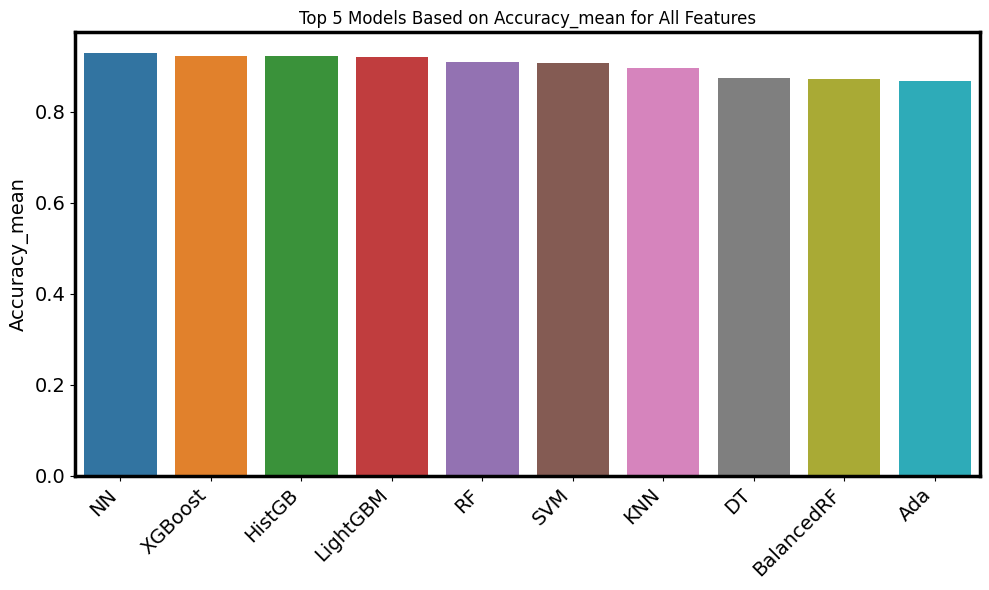

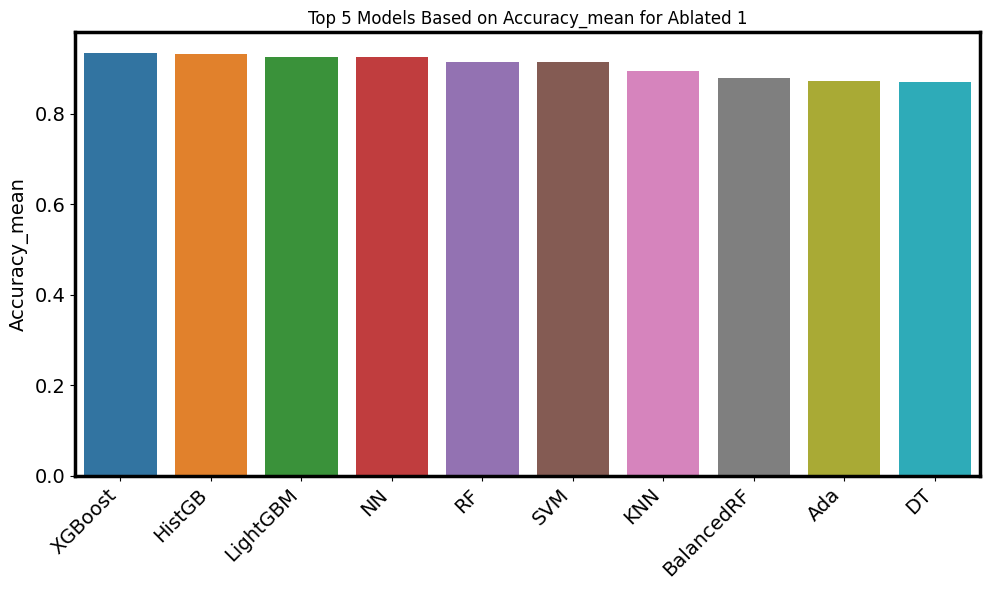

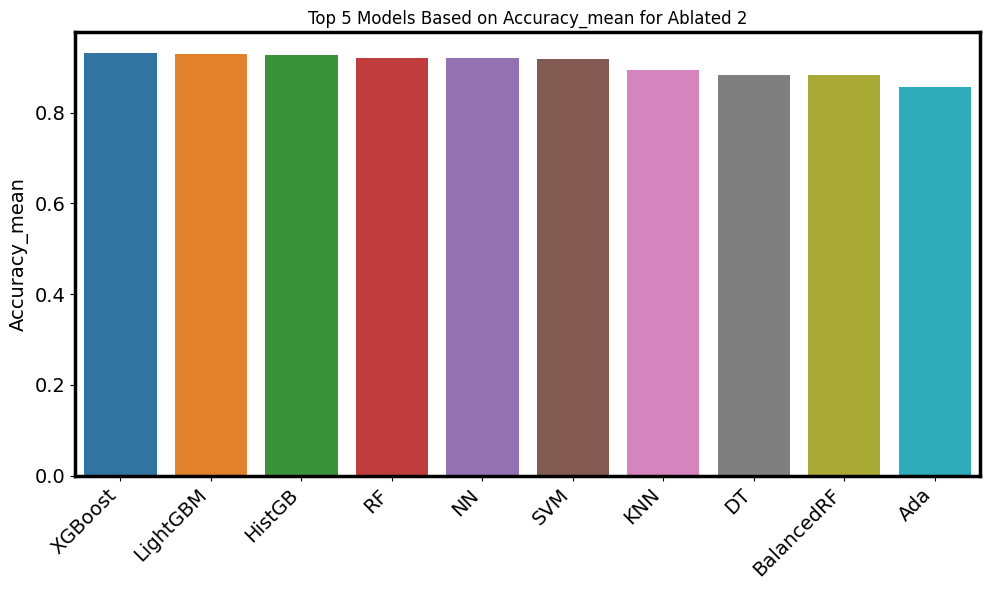

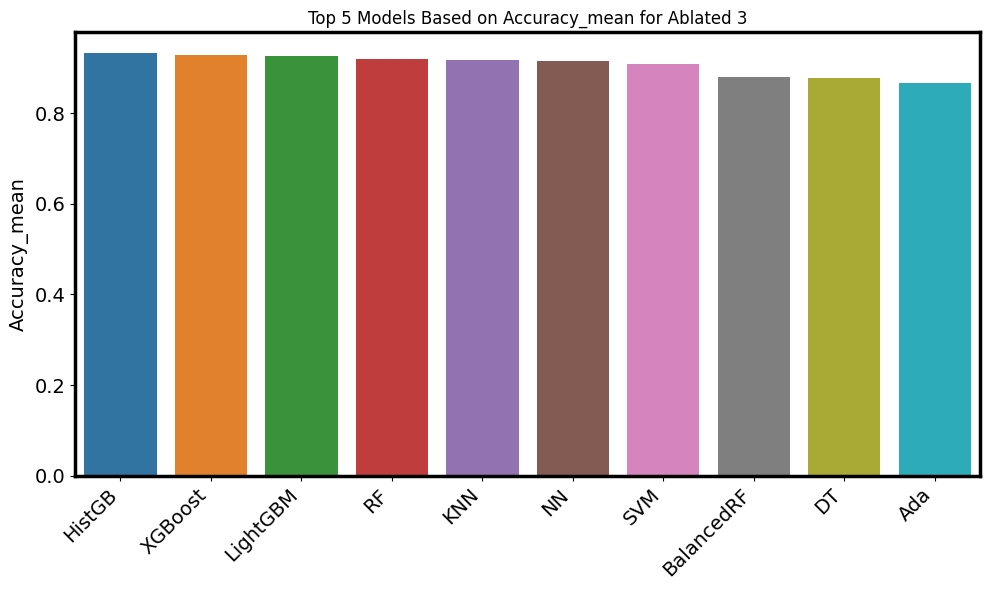

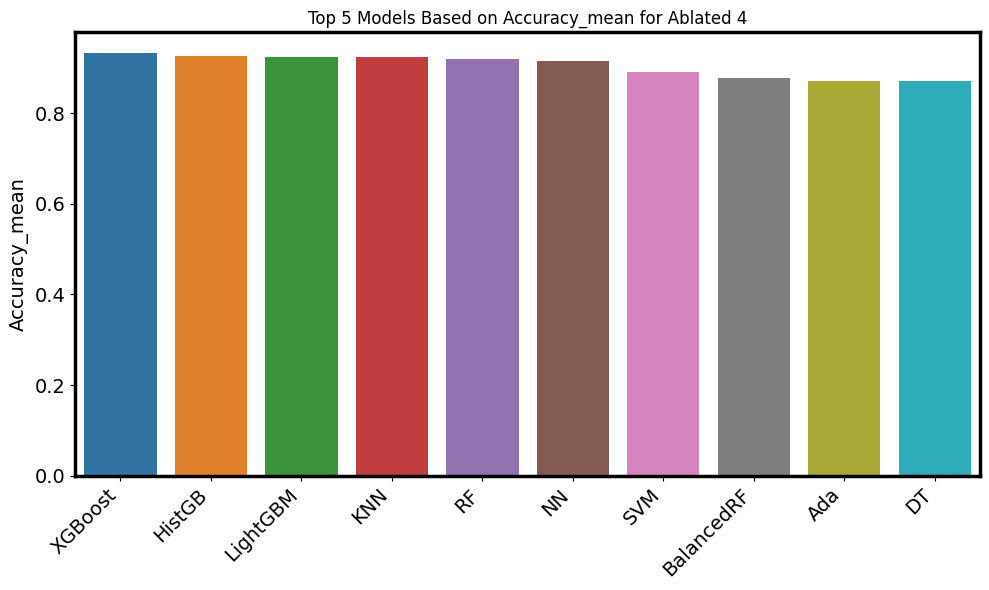

In [24]:
# Create bar charts for top 5 models based on 'Accuracy_mean'
create_bar_chart(final_results_df, 'Accuracy_mean')

In [25]:
# Function to create heatmaps
def create_heatmap(df, metric_mean, fontsize=16, title_pad=20, label_pad=15, figsize=(12, 8), 
                   colorbar_length=0.9, grid_thickness=0.6):
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Create a dataframe suitable for heatmaps
    heatmap_df = pd.DataFrame(index=df['Dataset'], columns=model_names)
    for model in model_names:
        heatmap_df[model] = df[f"{model}_{metric_mean}"].values

    # Reorder the columns based on descending accuracy on the "All Features" dataset
    all_features_accuracy = heatmap_df.loc['All Features'].sort_values(ascending=False)
    heatmap_df = heatmap_df[all_features_accuracy.index]
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=grid_thickness, 
                     linecolor='black', cbar_kws={"shrink": colorbar_length}, annot_kws={"size": fontsize-4})
    
    # Set title and labels with font sizes and paddings
    plt.title(f"Heatmap Based on {metric_mean}", fontsize=fontsize+6, pad=title_pad)
    plt.xlabel("Models", fontsize=fontsize+6, labelpad=label_pad)
    plt.ylabel("Datasets", fontsize=fontsize+6, labelpad=label_pad)
    plt.xticks(fontsize=fontsize, rotation=45, ha='right')
    plt.yticks(fontsize=fontsize, rotation=0, ha='right')

Saving figure metrics_heatmaps/Accuracy_heatmap.png
Saving figure metrics_heatmaps/F1 Score_heatmap.png
Saving figure metrics_heatmaps/Recall_heatmap.png
Saving figure metrics_heatmaps/Precision_heatmap.png
Saving figure metrics_heatmaps/ROC-AUC_heatmap.png
Saving figure metrics_heatmaps/Inference Time_heatmap.png
Saving figure metrics_heatmaps/Balling_heatmap.png
Saving figure metrics_heatmaps/Non-defective_heatmap.png
Saving figure metrics_heatmaps/LOF_heatmap.png
Saving figure metrics_heatmaps/Degradation_heatmap.png
Saving figure metrics_heatmaps/Laser-off_heatmap.png


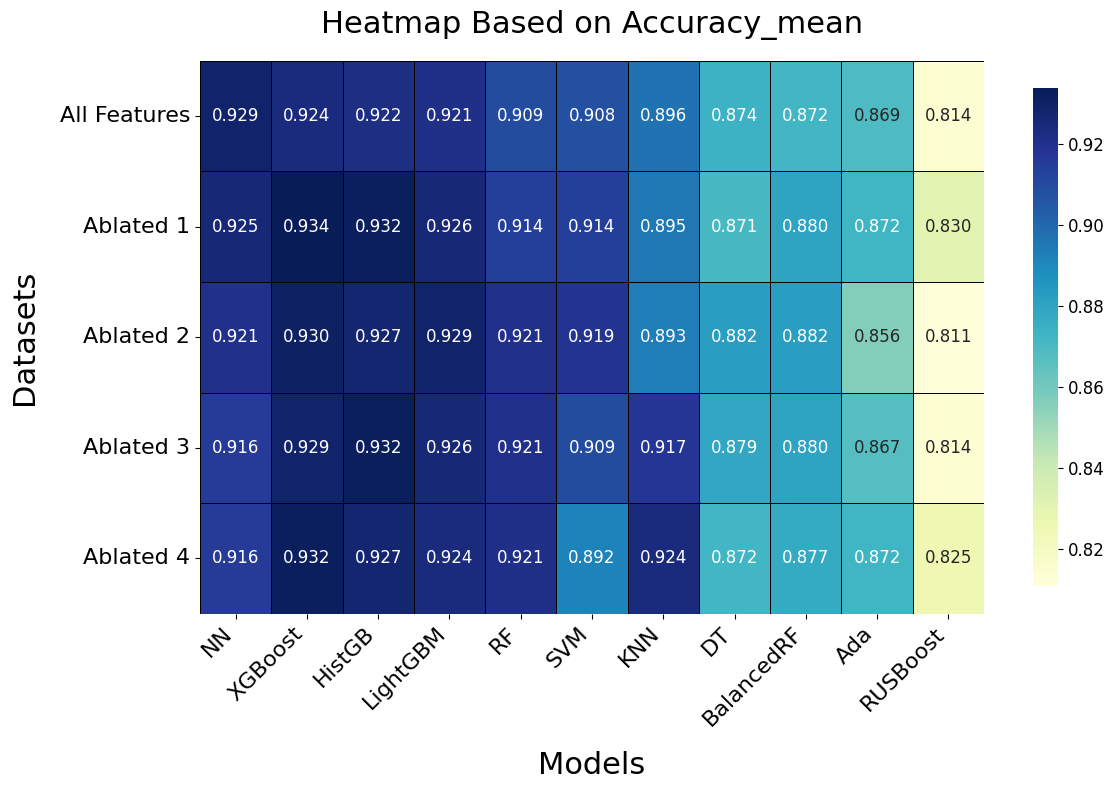

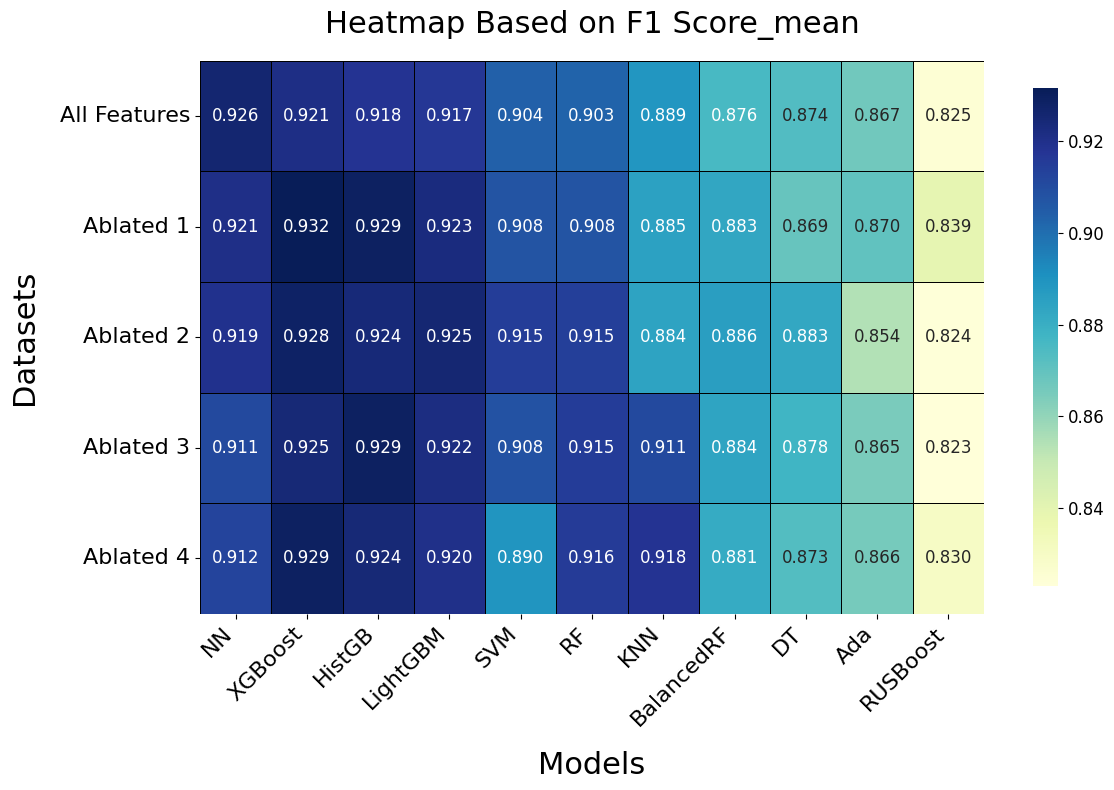

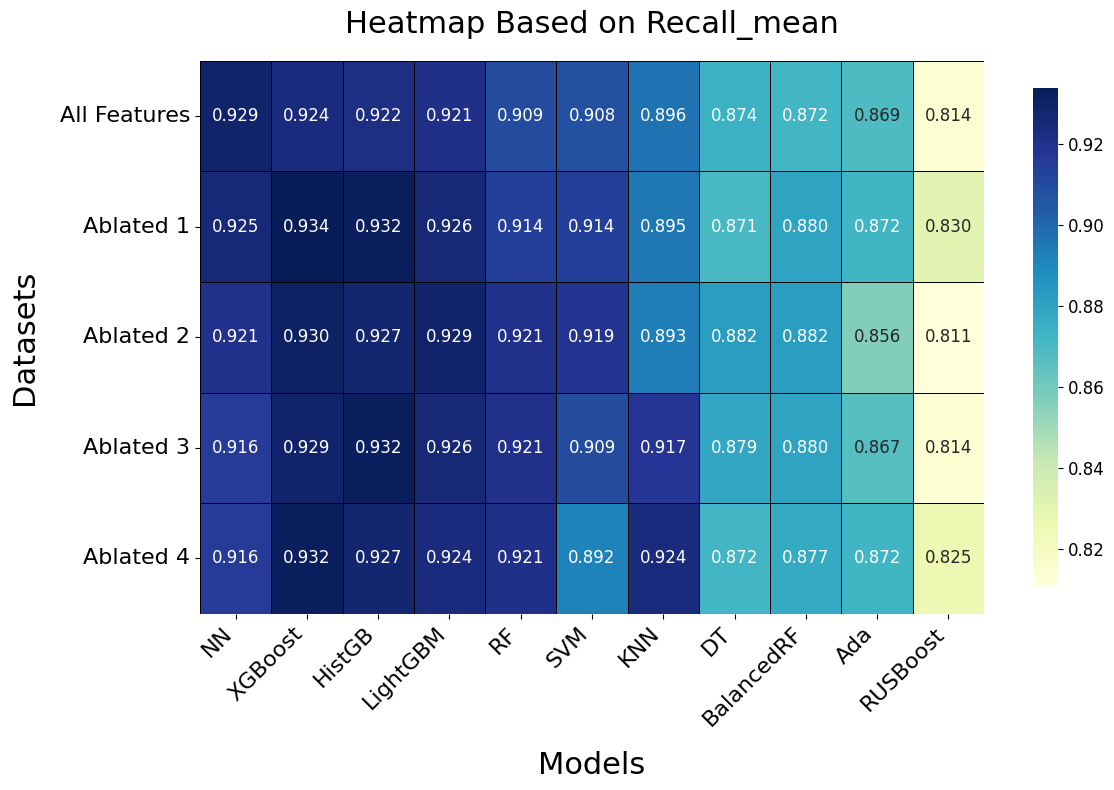

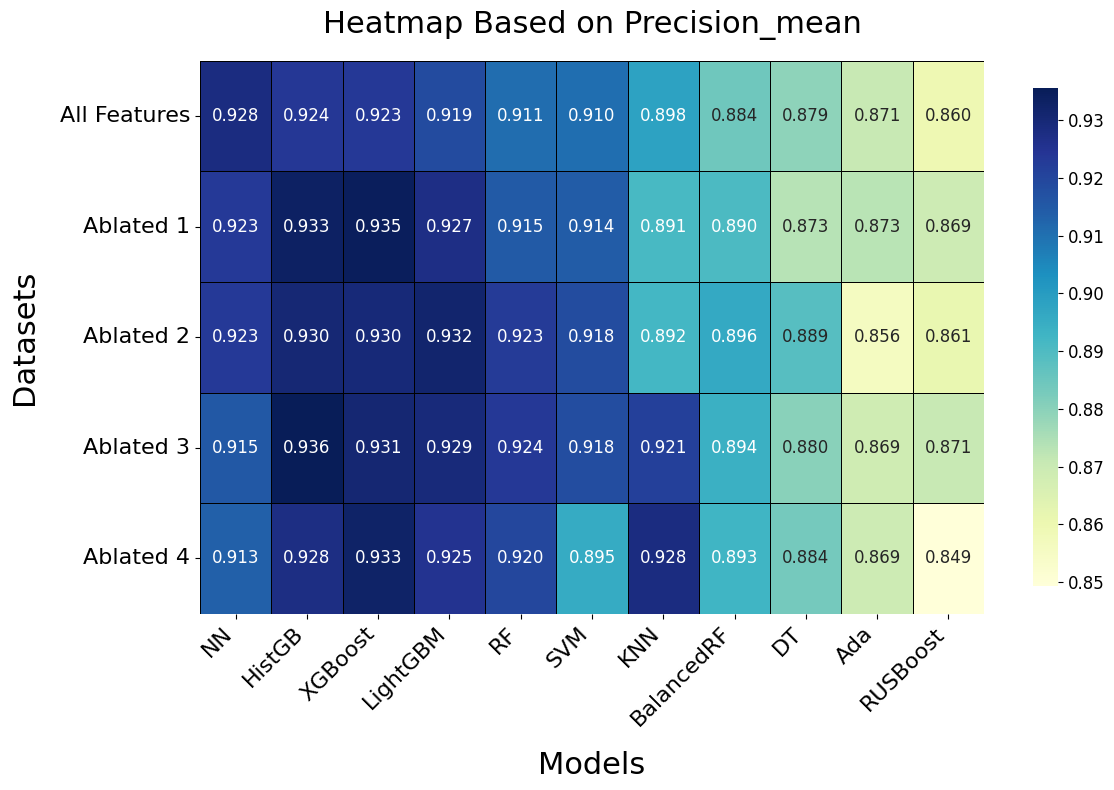

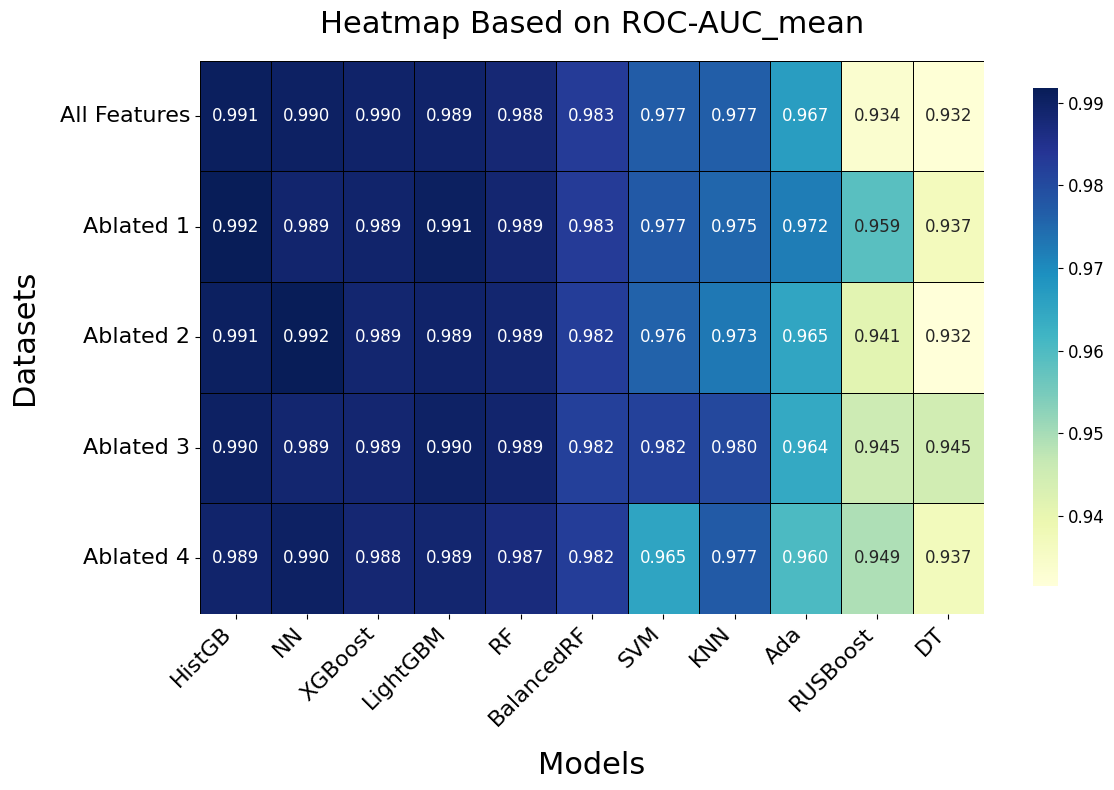

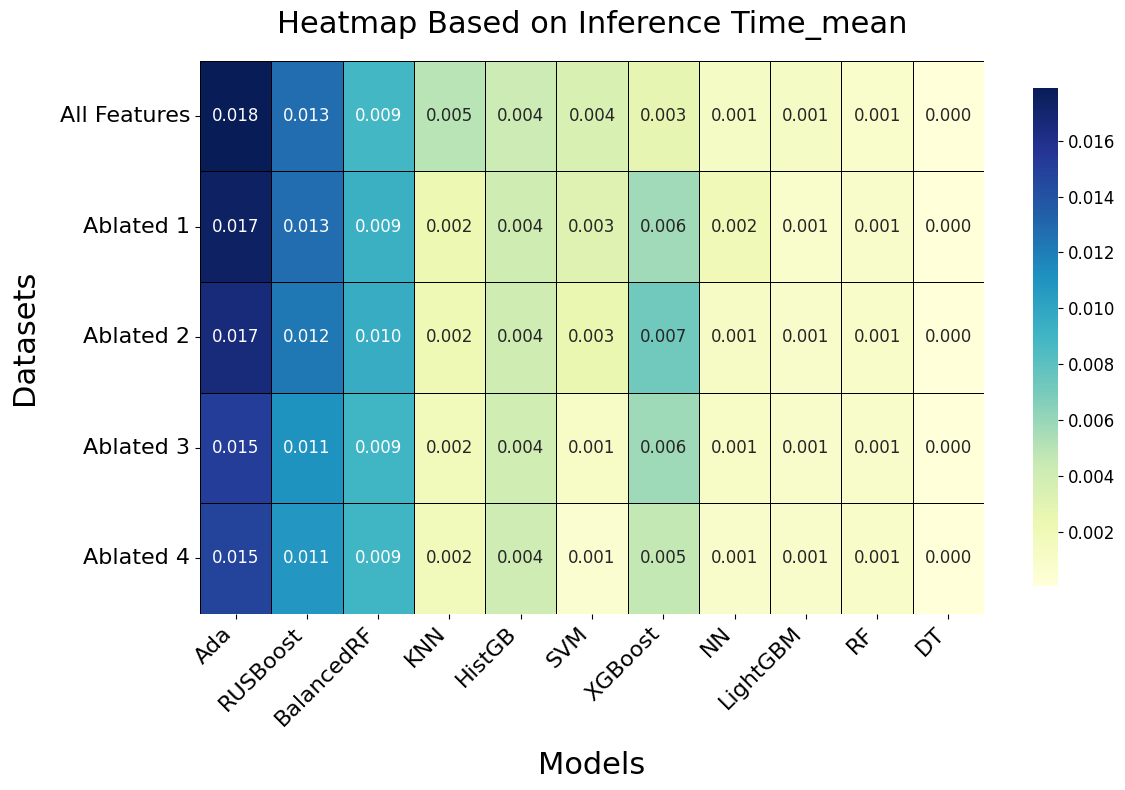

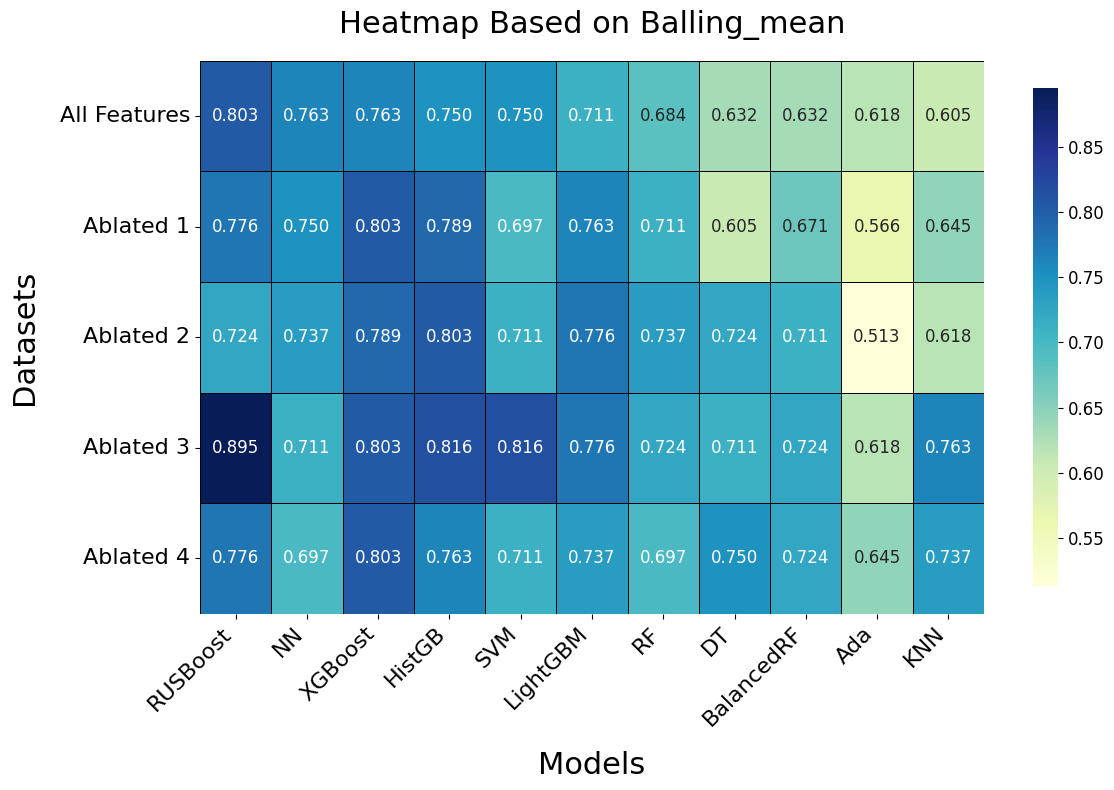

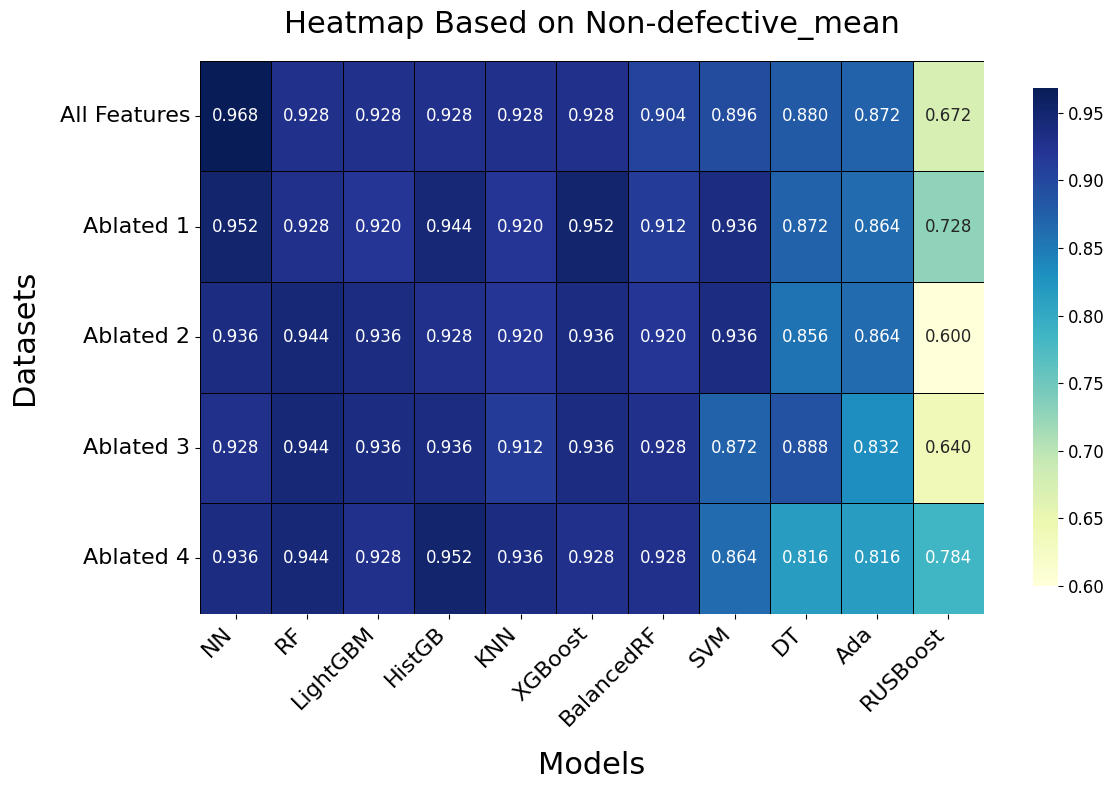

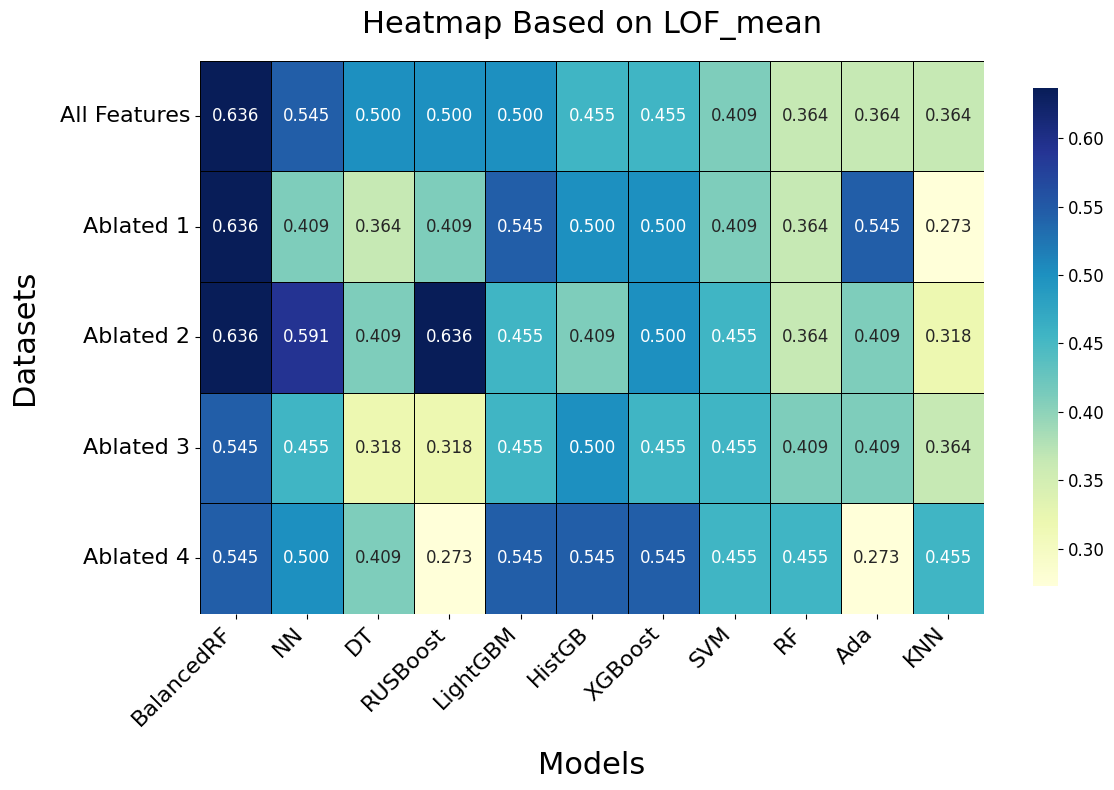

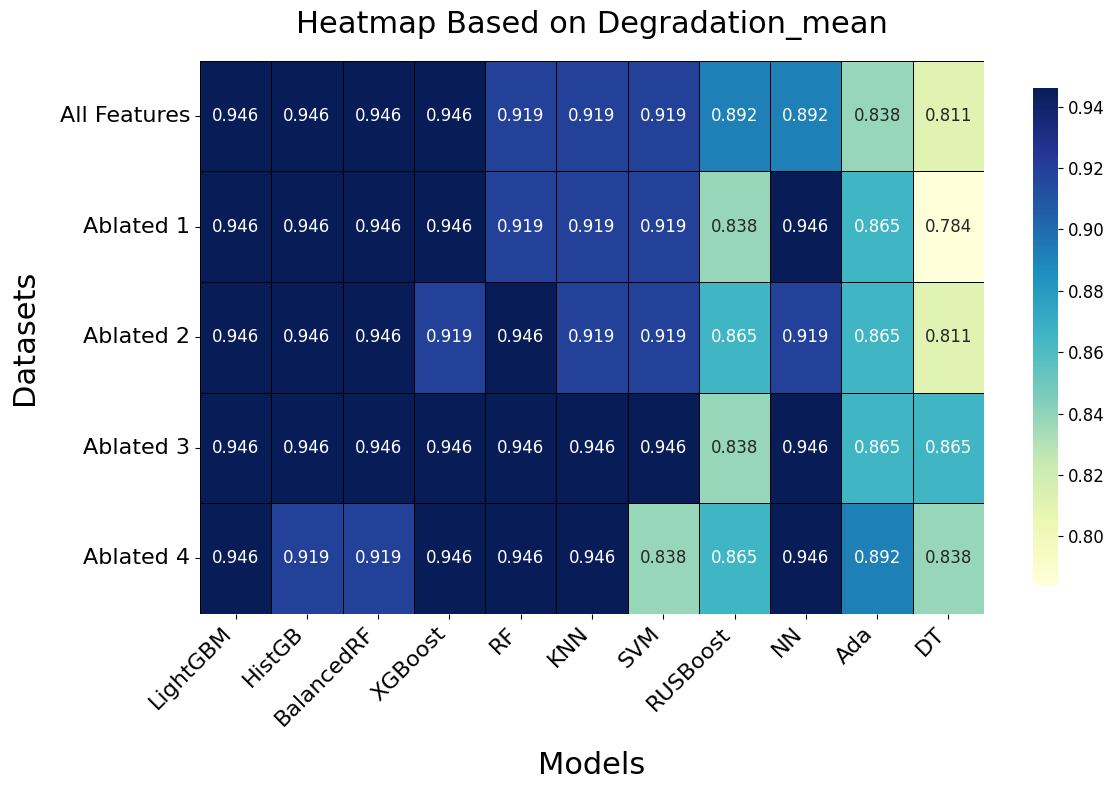

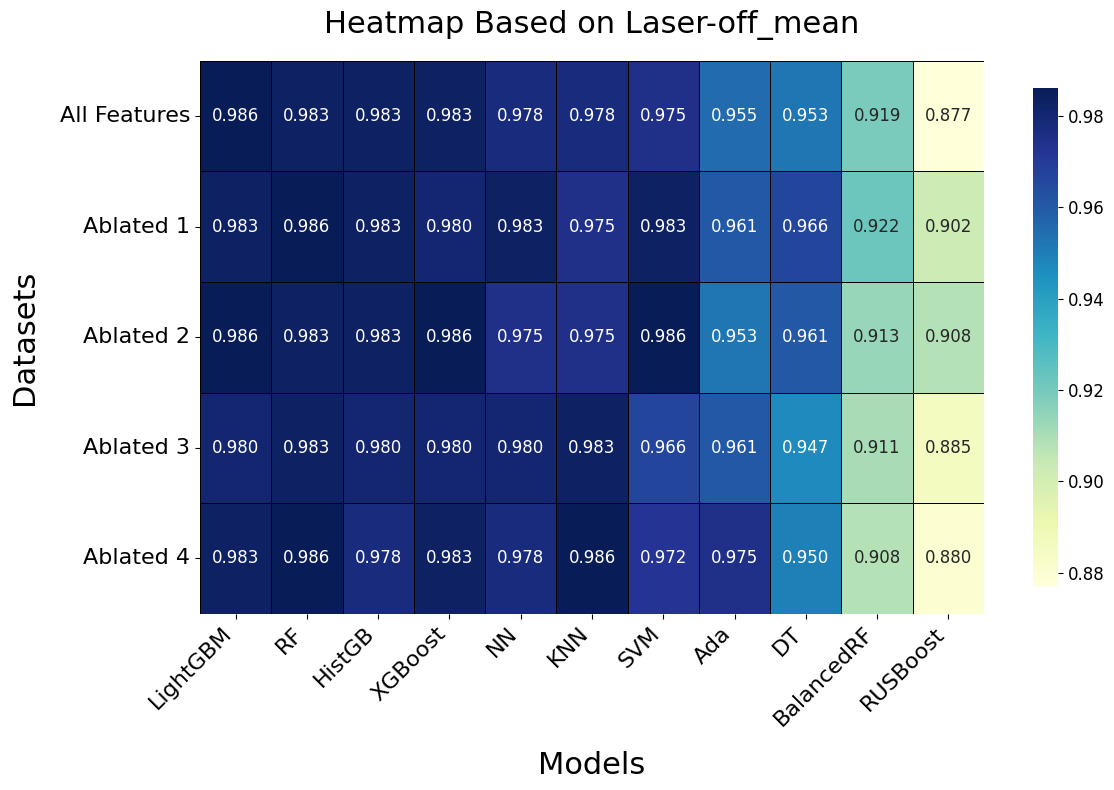

In [26]:
# Create a function to run create_heatmap for each evaluation metric and save the figure
def run_and_save_heatmaps(df, metrics, save_path, **kwargs):
    for metric in metrics:
        create_heatmap(df, f"{metric}_mean", **kwargs)
        save_fig(f"{save_path}/{metric}_heatmap.png")

# Uncomment the line below to run the function.
run_and_save_heatmaps(final_results_df, evaluation_metrics, save_path="metrics_heatmaps")